In [1]:
import os 
from typing import Dict, List, Tuple
from tqdm import tqdm
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [2]:
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

0
GeForce RTX 2060


# Reply buffer


In [3]:
class ReplayBuffer:
    def __init__(self, state_size: int, buffer_size: int, batch_zise: int):
        self.states_buf = np.zeros([buffer_size, state_size], dtype= np.float32)
        self.actions_buf = np.zeros([buffer_size], dtype= np.float32)
        self.rewards_buf = np.zeros([buffer_size], dtype = np.float32)
        self.next_states_buf = np.zeros([buffer_size, state_size], dtype= np.float32)
        self.done_buf = np.zeros([buffer_size], dtype= np.float32)
        self.max_size, self.batch_size = buffer_size, batch_size
        self.counter, self.size = 0, 0
        
    def store(self, transition: dict): #transition : dict

        self.states_buf[self.counter] = transition["state"]
        self.actions_buf[self.counter] = transition["action"]
        self.rewards_buf[self.counter] = transition["reward"]
        self.next_states_buf[self.counter] = transition["next_state"]
        self.done_buf[self.counter] = transition["done"]
        
        self.counter = (self.counter+1) % self.max_size
        self.size = min(self.size+1, self.max_size)
   
        
    def sample_batch(self) -> Dict[str, np.ndarray]:
        random_idx = np.random.choice(self.size, size= self.batch_size, replace=False)
        random_samples = dict(states=self.states_buf[random_idx], 
                              actions=self.actions_buf[random_idx],
                              rewards=self.rewards_buf[random_idx],
                              next_states=self.next_states_buf[random_idx],
                              done=self.done_buf[random_idx])
        return random_samples

# Network

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Network, self).__init__()

        
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.ReLU())
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)
        

# DQN Agent

In [5]:
class DQNAgent:
    
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        hard_update_every: int,
        epsilon_param: dict,
        gamma:float,
    ):
        
        states_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        #Initialization
        self.env = env
        self.memory = ReplayBuffer(states_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.hard_update_every = hard_update_every
        self.epsilon_max = epsilon_param['epsilon_max']
        self.epsilon_min = epsilon_param['epsilon_min']
        self.epsilon_decay = epsilon_param['epsilon_decay']
        self.epsilon = self.epsilon_max
        self.gamma = gamma
        
        #device: cpu or gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        #Initialization of the networks
        self.dqn = Network(states_dim, action_dim).to(self.device)
        self.target_dqn = Network(states_dim, action_dim).to(self.device)
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.target_dqn.eval()
        # .eval(): will notify all your layers that you are in eval mode, that way, 
        #batchnorm or dropout layers will work in eval mode instead of training mode
        
        #optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())
        
        #transition to store in memory
        self.transition = dict()
        
        #mode: train or test
        self.is_training = True
        
############################# Action selection#################################     
    
    def select_action(self, state: np.ndarray)-> np.ndarray:
        
        
        if self.epsilon > np.random.random() : #explore
            selected_action = self.env.action_space.sample()
        else: #exploit
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy() #convert action from tensor to numpy
        
        if self.is_training:
            self.transition['state']= state
            self.transition['action']= selected_action
        
        return selected_action
    
############################# Take action#################################      

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float32, bool]:

        next_state, reward, done, _ = self.env.step(action)

        if self.is_training:
            self.transition['next_state']= next_state
            self.transition['reward']= reward
            self.transition['done']= done
            self.memory.store(self.transition)

        return next_state, reward, done
    
############################# Update action#################################         
    def update_model(self):
    
        samples = self.memory.sample_batch()

        loss = self._compute_network_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
############################# Compute network Loss#################################
    def _compute_network_loss(self, samples: dict) -> torch.Tensor:
        
        states = torch.FloatTensor(samples['states']).to(self.device)
        actions = torch.FloatTensor(samples['actions'].reshape(-1,1)).to(self.device)
        rewards = torch.FloatTensor(samples['rewards'].reshape(-1,1)).to(self.device)
        next_states = torch.FloatTensor(samples['next_states']).to(self.device)
        done = torch.FloatTensor(samples['done'].reshape(-1,1)).to(self.device)
        
        
        current_q_values = self.dqn(states).gather(1,actions.type(torch.LongTensor).to(self.device))
        
        #Dqn(state) will output all the Q-values for all the actions 
        #USing gather(1, action) we will return just the Q-value of the chosen actions

        next_q_values = self.target_dqn(next_states).max(dim=1, keepdim=True)[0].detach()

        #Get max Q value from the target network
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        
        mask = 1 - done
        
        targets = (rewards + self.gamma * next_q_values * mask).to(self.device)
        
        #calculate dqn loss
        loss = F.smooth_l1_loss(current_q_values, targets)
        
        return loss
############################# Training #################################    
    def train(self, episodes: int):
        self.is_training = True
 
        #state = self.env.reset()
        
        done_count = 0
        epsilons_list = []
        losses_list = []
        reward_list = []
        
        ep_len = 0
        losses = 0
        score = 0
        
        state = self.env.reset()
        
        for ep in tqdm(range(1, episodes+1)):
            
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            ep_len +=1
                
            if self.memory.size >= self.batch_size:
                
                loss = self.update_model()
                losses+=loss
                
                self.epsilon = max(0.1, 0.9997*self.epsilon)
                epsilons_list.append(self.epsilon)
                
                
            
            if done:
                state = self.env.reset()
                reward_list.append(score)
                losses_list.append(losses/ep_len)
                self._target_hard_update()
                
                done_count+=1
                ep_len = 0
                losses = 0
                score = 0        
            
                if done_count % 25== 0:
                    tqdm.write(
                        "Episode: [{}/{}], score: {}, loss: {:.6f}".format(ep, episodes, np.average(reward_list[-25:]), losses)
                    )
        
        self.env.close()
        return losses_list, reward_list, epsilons_list
    
############################# Testing #################################        
    
    def test(self):
        self.is_training = False
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            
            frames.append(env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
            
############################# Hard update for the DQN network ################################# 

    def _target_hard_update(self,):
        
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        

## Plot epsilon test

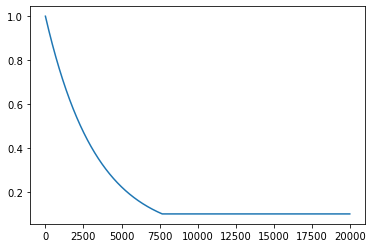

In [6]:
episodes = 20000
max_epsilon: float = 1.0
min_epsilon: float = 0.01
epsilon_decay = 5/episodes
epsilons = []
ep = 1.0
for step in range(episodes):
    #epsilons.append( max(min_epsilon, min_epsilon + (max_epsilon - min_epsilon)* \
    #                               np.exp(-epsilon_decay*step)) )
    
#     if ep > 0.05 :
#         ep -= (1 / 500)
    ep = max(0.1, 0.9997*ep)
    epsilons.append(ep)

plt.plot(epsilons)

# Main

## Environement and seeds

In [7]:
# environment
env_id = "CartPole-v0" 
 # "MountainCar-v0"
env = gym.make(env_id)

In [8]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 43
np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[43]

In [9]:
torch.backends.cudnn.enabled

True

## Parameters

In [10]:
episodes = 20000
memory_size = 10000
batch_size = 32
hard_update_every = 200

# epsilon_param = [eps_max, eps_min, eps_decay]
epsilon_param = dict()
epsilon_param['epsilon_max'] = 1
epsilon_param['epsilon_min'] = 0.01
epsilon_param['epsilon_decay']= 10/ episodes

gamma = 0.97

In [11]:
#Build our smart agent
agent = DQNAgent(env, memory_size, batch_size, hard_update_every, epsilon_param, gamma)

cuda


In [12]:
#train model
losses_list, reward_list, epsilons_list = agent.train(episodes)

  3%|█▉                                                                           | 513/20000 [00:04<02:47, 116.31it/s]

Episode: [499/20000], score: 19.96, loss: 0.000000


  5%|███▊                                                                         | 989/20000 [00:08<02:52, 110.07it/s]

Episode: [974/20000], score: 19.0, loss: 0.000000


  7%|█████▍                                                                      | 1423/20000 [00:12<02:55, 105.79it/s]

Episode: [1413/20000], score: 17.56, loss: 0.000000


 11%|████████▏                                                                   | 2170/20000 [00:19<02:41, 110.31it/s]

Episode: [2152/20000], score: 29.56, loss: 0.000000


 17%|█████████████▎                                                              | 3499/20000 [00:31<02:31, 108.83it/s]

Episode: [3485/20000], score: 53.32, loss: 0.000000


 28%|█████████████████████▌                                                      | 5679/20000 [00:52<02:22, 100.50it/s]

Episode: [5662/20000], score: 87.08, loss: 0.000000


 48%|████████████████████████████████████▋                                        | 9517/20000 [01:30<01:45, 99.36it/s]

Episode: [9503/20000], score: 153.64, loss: 0.000000


 66%|█████████████████████████████████████████████████▍                         | 13194/20000 [02:07<01:05, 104.13it/s]

Episode: [13176/20000], score: 146.92, loss: 0.000000


 83%|██████████████████████████████████████████████████████████████▉             | 16555/20000 [02:41<00:35, 97.10it/s]

Episode: [16543/20000], score: 134.68, loss: 0.000000


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:15<00:00, 102.35it/s]


## Plot

In [13]:
def plot(episodes, losses_list, reward_list, epsilons_list):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('rewards')
        plt.plot(reward_list)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses_list)
        #plt.ylim(0, 10)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons_list)
        plt.show()

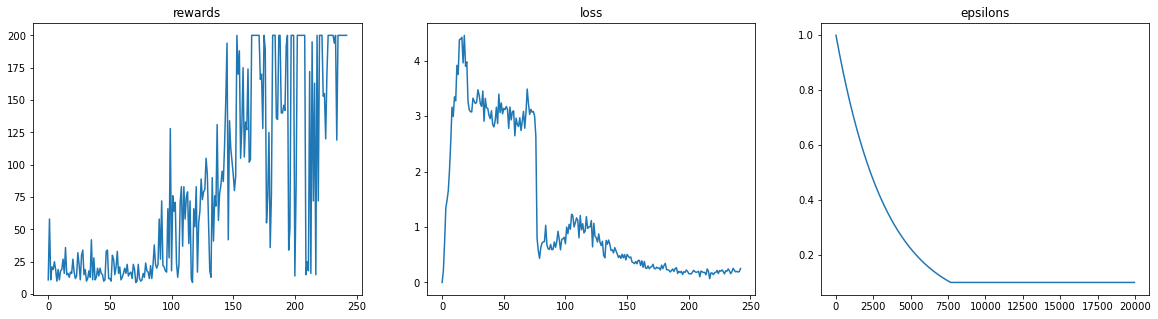

In [14]:
plot(episodes, losses_list, reward_list, epsilons_list)

In [15]:
#test model
agent.test()

score:  200.0


In [16]:
#%mkdir checkpoint best_model
checkpoint = {'model': agent.dqn,
              'state_dict': agent.dqn.state_dict(),
              'optimizer' : agent.optimizer.state_dict()}

In [17]:
torch.save(checkpoint, "best_model/checkpoint.pt")


C:\Users\omarb\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
agent.dqn.parameters()

<generator object Module.parameters at 0x0000027110CF8F48>

In [19]:
agent0 = DQNAgent(env, memory_size, batch_size, hard_update_every, epsilon_param, gamma)
checkpoint = torch.load("best_model/checkpoint.pt")
agent0.dqn = checkpoint['model']
agent0.dqn.load_state_dict(checkpoint['state_dict'])
for parameter in agent0.dqn.parameters():
    parameter.requires_grad = False
    
agent0.dqn.eval()
    

cuda


Network(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): ReLU()
  )
)

In [20]:
#test model
agent0.test()

score:  17.0
